# Taxi demand predicting 🚕

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

**Требование по качеству:** `RMSE <= 48` на тестовой выборке

**Содержание**<a id='toc0_'></a>    
1. [Подготовка           ](#toc1_)    
1.1. [Библиотеки           ](#toc1_1_)    
1.2. [Конфигурация           ](#toc1_2_)    
1.3. [Сервисные функции           ](#toc1_3_)    
2. [Данные           ](#toc2_)    
2.1. [Загрузка           ](#toc2_1_)    
2.2. [Проверка типов данных           ](#toc2_2_)    
2.3. [Проверка пропусков           ](#toc2_3_)    
2.4. [Ресемплирование           ](#toc2_4_)    
2.5. [Изучение признаков         ](#toc2_5_)    
2.6. [Проверка стационарности ряда     ](#toc2_6_)    
2.7. [Анализ сезонностей     ](#toc2_7_)    
2.7.1. [Дневная     ](#toc2_7_1_)    
2.7.2. [Недельная     ](#toc2_7_2_)    
2.8. [Годовая    ](#toc2_8_)    
2.9. [Вывод по датасету        ](#toc2_9_)    
3. [Модели           ](#toc3_)    
3.1. [Подготовка        ](#toc3_1_)    
3.2. [`LinearRegression`        ](#toc3_2_)    
3.3. [`RandomForestRegressor`        ](#toc3_3_)    
3.4. [`LGBMRegressor`        ](#toc3_4_)    
3.5. [`CatBoostRegressor`        ](#toc3_5_)    
4. [Результаты        ](#toc4_)    
4.1. [Сравнение моделей       ](#toc4_1_)    
4.2. [Проверка на тесте   ](#toc4_2_)    
4.3. [Важность признаков      ](#toc4_3_)    
4.4. [Анализ предсказаний  ](#toc4_4_)    
5. [Общий вывод           ](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка            [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки            [&#8593;](#toc0_)

In [1]:
from  IPython.display import clear_output

In [2]:
%pip install -q catboost==1.2.7
%pip install -q hyperopt==0.2.7
%pip install -q lightgbm==4.5.0
%pip install -q matplotlib==3.8.4
%pip install -q numpy==1.26.4
%pip install -q pandas==2.2.3
%pip install -q phik==0.12.4
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q seaborn==0.13.2
%pip install -q shap==0.46.0
%pip install -q statsmodels==0.14.4
%pip install -q termcolor==2.5.0

clear_output()

In [3]:
from os.path import exists


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Hyperparams tuning
from hyperopt import (hp,
                      fmin,
                      tpe,
                      Trials,
                      STATUS_OK)

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

/Users/rivel/anaconda3/envs/ml12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2. <a id='toc1_2_'></a>Конфигурация            [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.1

### 1.3. <a id='toc1_3_'></a>Сервисные функции            [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str], **kwargs) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path, **kwargs)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid for correct csv file.')

In [6]:
def check_nans(df: pd.DataFrame) -> None:
    if df.isna().sum().sum() == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = df.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(df):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [7]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

## 2. <a id='toc2_'></a>Данные            [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка            [&#8593;](#toc0_)

In [8]:
df = get_dataframe([
        './data/taxi.csv',
        '/datasets/taxi.csv',
        'https://code.s3.yandex.net/datasets/taxi.csv'
    ], parse_dates=['datetime'], index_col='datetime'
).sort_index()

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### 2.2. <a id='toc2_2_'></a>Проверка типов данных            [&#8593;](#toc0_)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
df.index.is_monotonic_increasing

True

### 2.3. <a id='toc2_3_'></a>Проверка пропусков            [&#8593;](#toc0_)

In [12]:
check_nans(df)

Полных дубликатов не обнаружено.


### 2.4. <a id='toc2_4_'></a>Ресемплирование            [&#8593;](#toc0_)

Предсказание нужно сделать на следующий час, поэтому ресемпилируем по одному часу.

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [14]:
df = df.resample('1h').sum()

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### 2.5. <a id='toc2_5_'></a>Изучение признаков          [&#8593;](#toc0_)

In [16]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

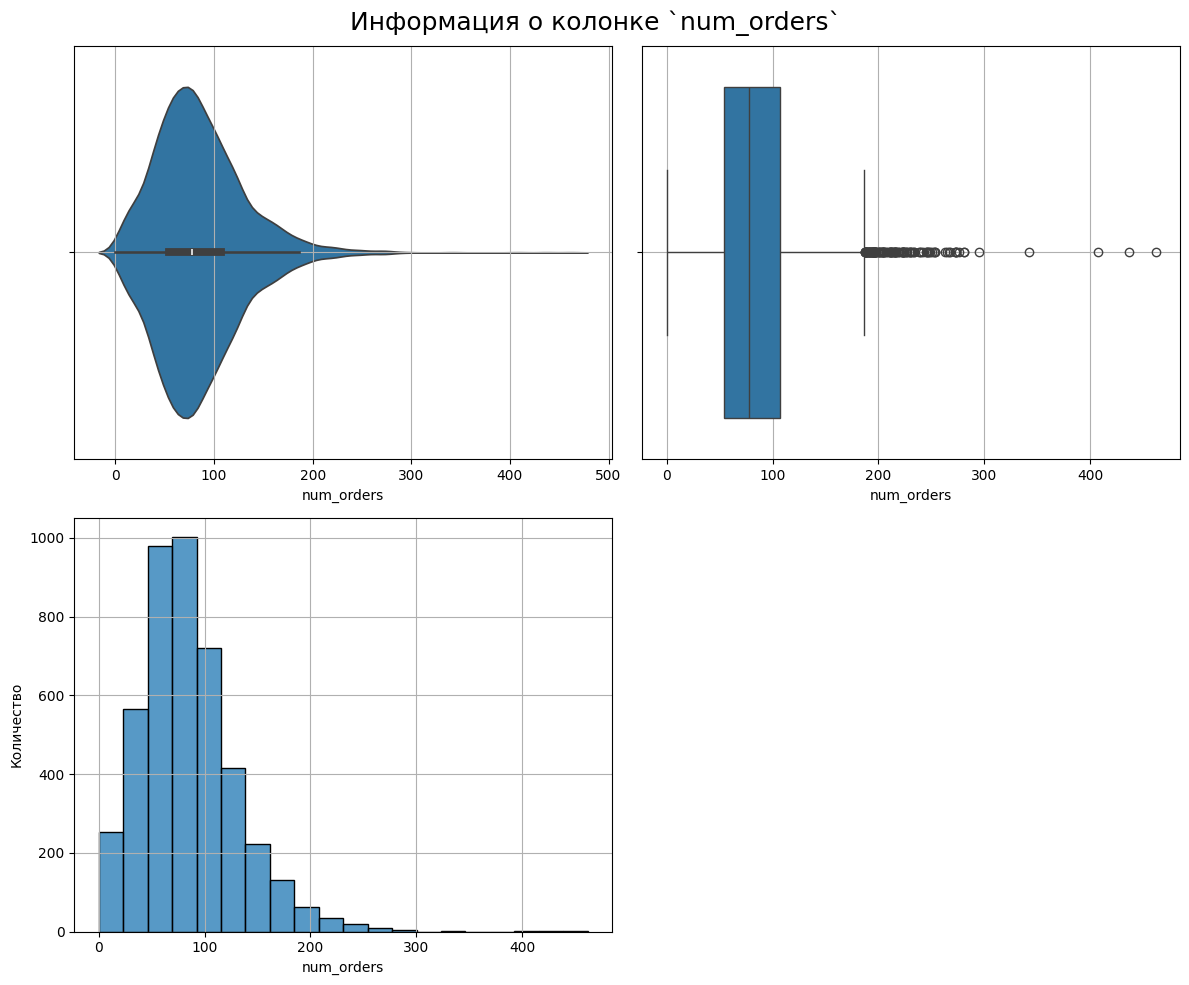

In [17]:
draw_plots_about_column(df, 'num_orders')

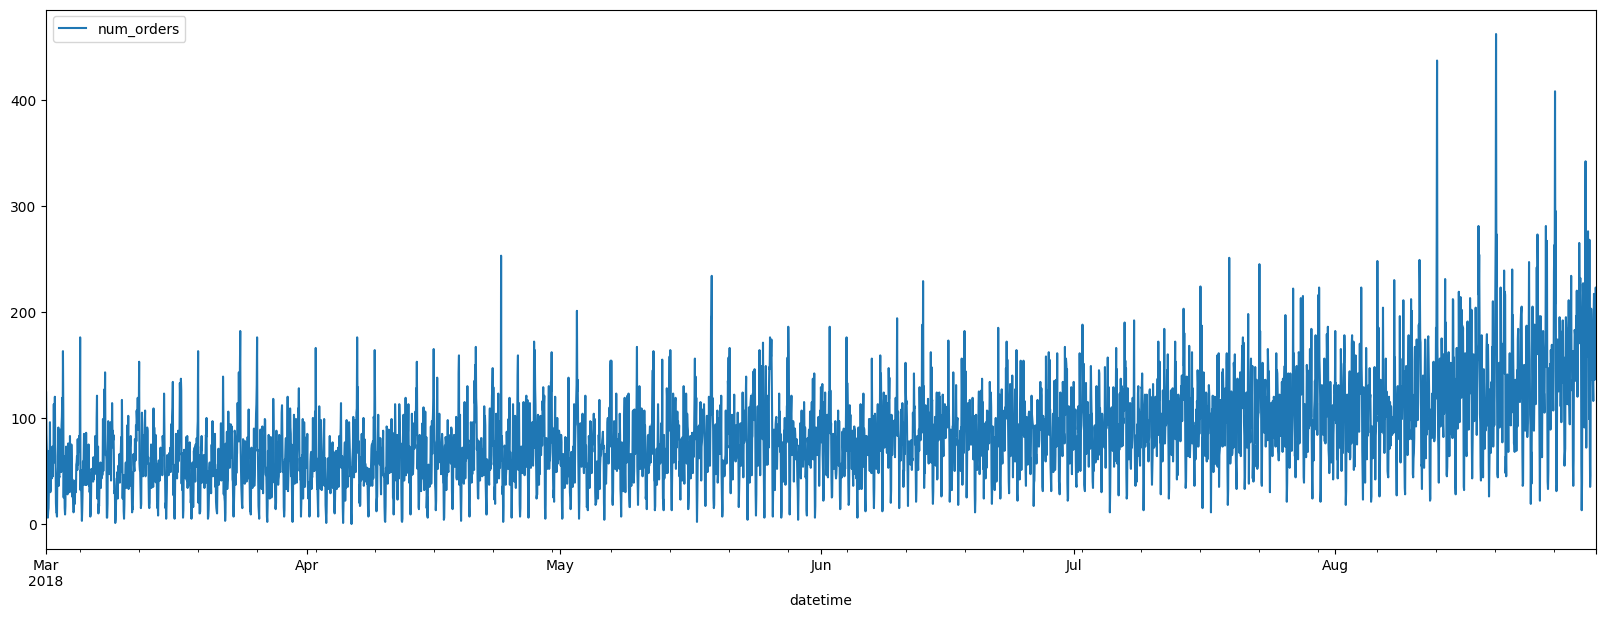

In [18]:
_ ,ax = plt.subplots(figsize=(20, 7))
df.plot(ax=ax);

In [19]:
df_for_analysis = df.copy()

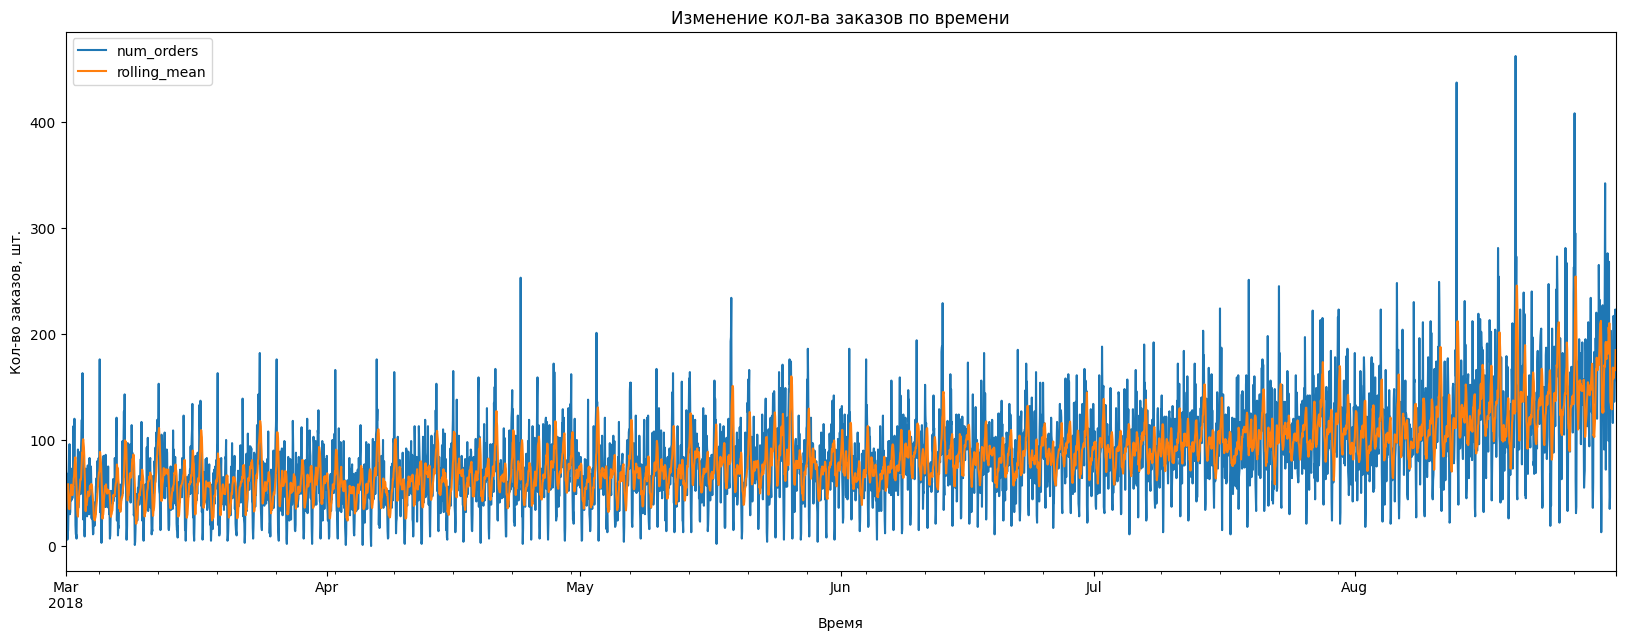

In [20]:
_ ,ax = plt.subplots(figsize=(20, 7))
df_for_analysis['rolling_mean'] = df_for_analysis['num_orders'].shift().rolling(7).mean()
df_for_analysis.plot(ax=ax)
plt.title('Изменение кол-ва заказов по времени')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов, шт.')
plt.show()

### 2.6. <a id='toc2_6_'></a>Проверка стационарности ряда      [&#8593;](#toc0_)

Оценим стационарность ряда с помощью теста Дики-Фуллера. Сформулируем гипотезы:  
$H_0$ - ряд нестационарен  
$H_1$ - ряд стационарен

In [21]:
test = adfuller(df)
adf = test[0]
p_value = test[1]
critical_values = test[4]

print(f'adf = {adf}')
print(f'p-value = {p_value}')
print(f'Critical value: {critical_values}')

if test[0] > test[4]['5%']:
    print('Ряд не стационарен (alpha = 0.01)')
else:
    print('Ряд стационарен (alpha = 0.05)')
    if test[0] > test[4]['1%']:
        print('Ряд не стационарен (alpha = 0.01)')
    else:
        print('Ряд стационарен (alpha = 0.01)')

adf = -3.0689242890279256
p-value = 0.028940051402615317
Critical value: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Ряд стационарен (alpha = 0.05)
Ряд не стационарен (alpha = 0.01)


### 2.7. <a id='toc2_7_'></a>Анализ сезонностей      [&#8593;](#toc0_)

#### 2.7.1. <a id='toc2_7_1_'></a>Дневная      [&#8593;](#toc0_)

In [22]:
df_resampled_hours = df['2018-03-05':'2018-03-07']
df_resampled_hours.head()

,num_orders
datetime,
2018-03-05 00:00:00,86
2018-03-05 01:00:00,176
2018-03-05 02:00:00,32
2018-03-05 03:00:00,51
2018-03-05 04:00:00,34


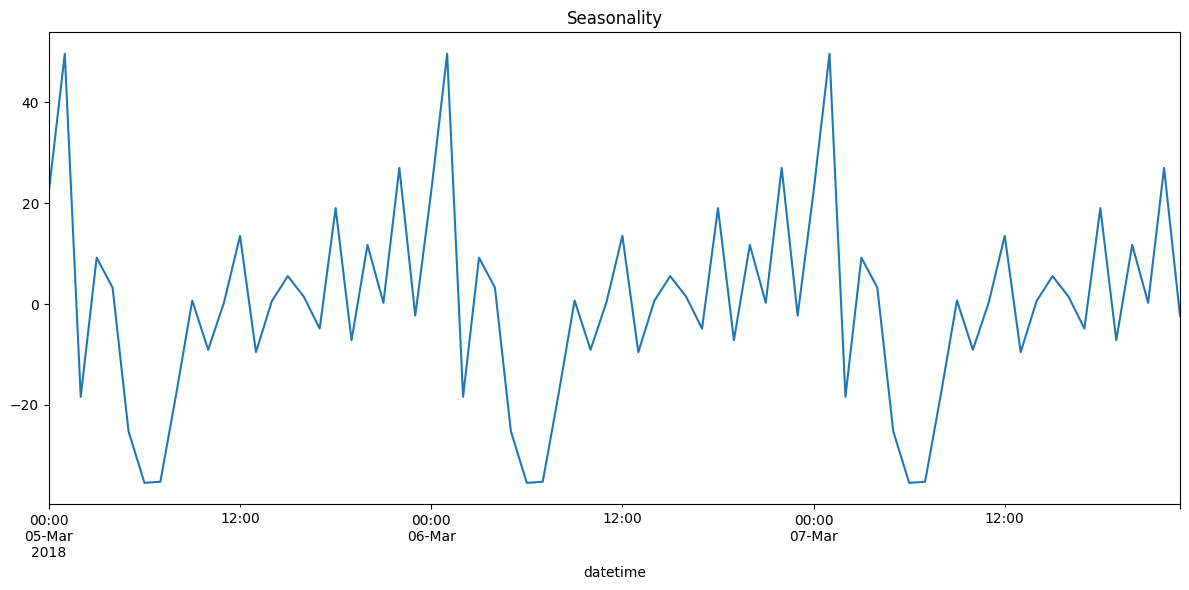

In [23]:
decomposed_days = seasonal_decompose(df_resampled_hours)
plt.figure(figsize=(12, 6))
decomposed_days.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()
plt.show()

Наблюдаем дневную сезонность. Наибольший спрос на такси наблюдается в вечерние часы и особенно ночью (около часа ночи). Это можно объяснить тем, что люди возвращаются из различных мест (рестораны, кино и т.д.), а общественный транспорт уже практически не ходит.

#### 2.7.2. <a id='toc2_7_2_'></a>Недельная      [&#8593;](#toc0_)

In [24]:
df_resampled_days = df.resample('1d').sum()
df_resampled_days = df_resampled_days['2018-03-05':'2018-04-01']  # Возьмем информацию за 4 недели
df_resampled_days.head()

,num_orders
datetime,
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441
2018-03-08,1659
2018-03-09,1076


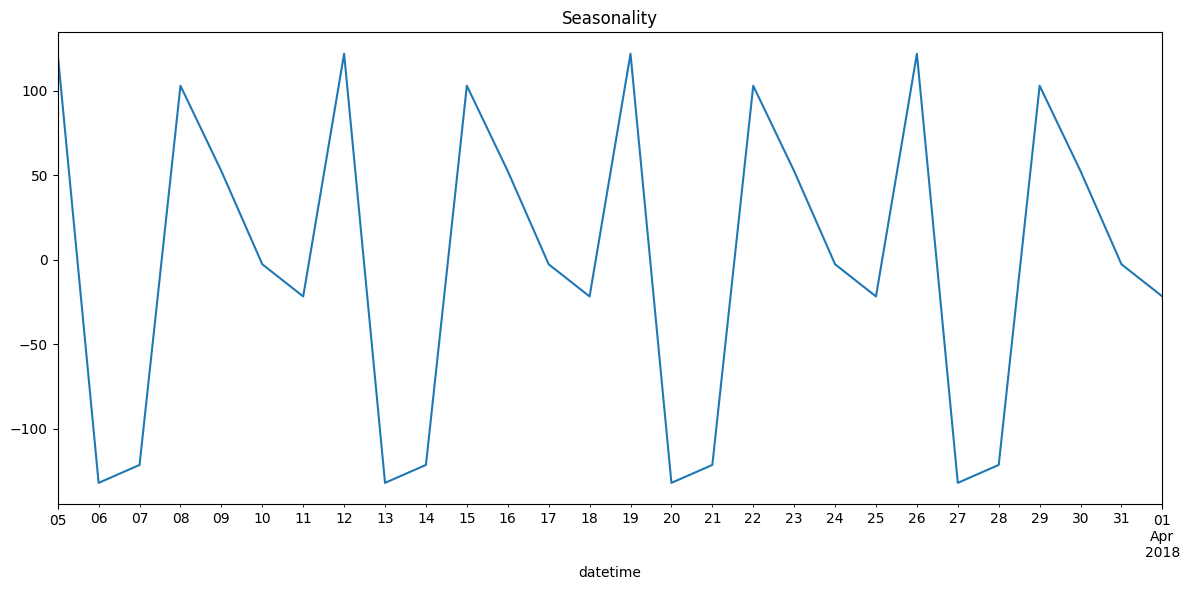

In [25]:
decomposed_days = seasonal_decompose(df_resampled_days)
plt.figure(figsize=(12, 6))
decomposed_days.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()
plt.show()

Наблюдается недельная сезонность. По вторникам и средам количество заказов минимально. А вот в понедельник и четверг их количество куда выше.

### 2.8. <a id='toc2_8_'></a>Годовая     [&#8593;](#toc0_)

In [26]:
decomposed = seasonal_decompose(df)

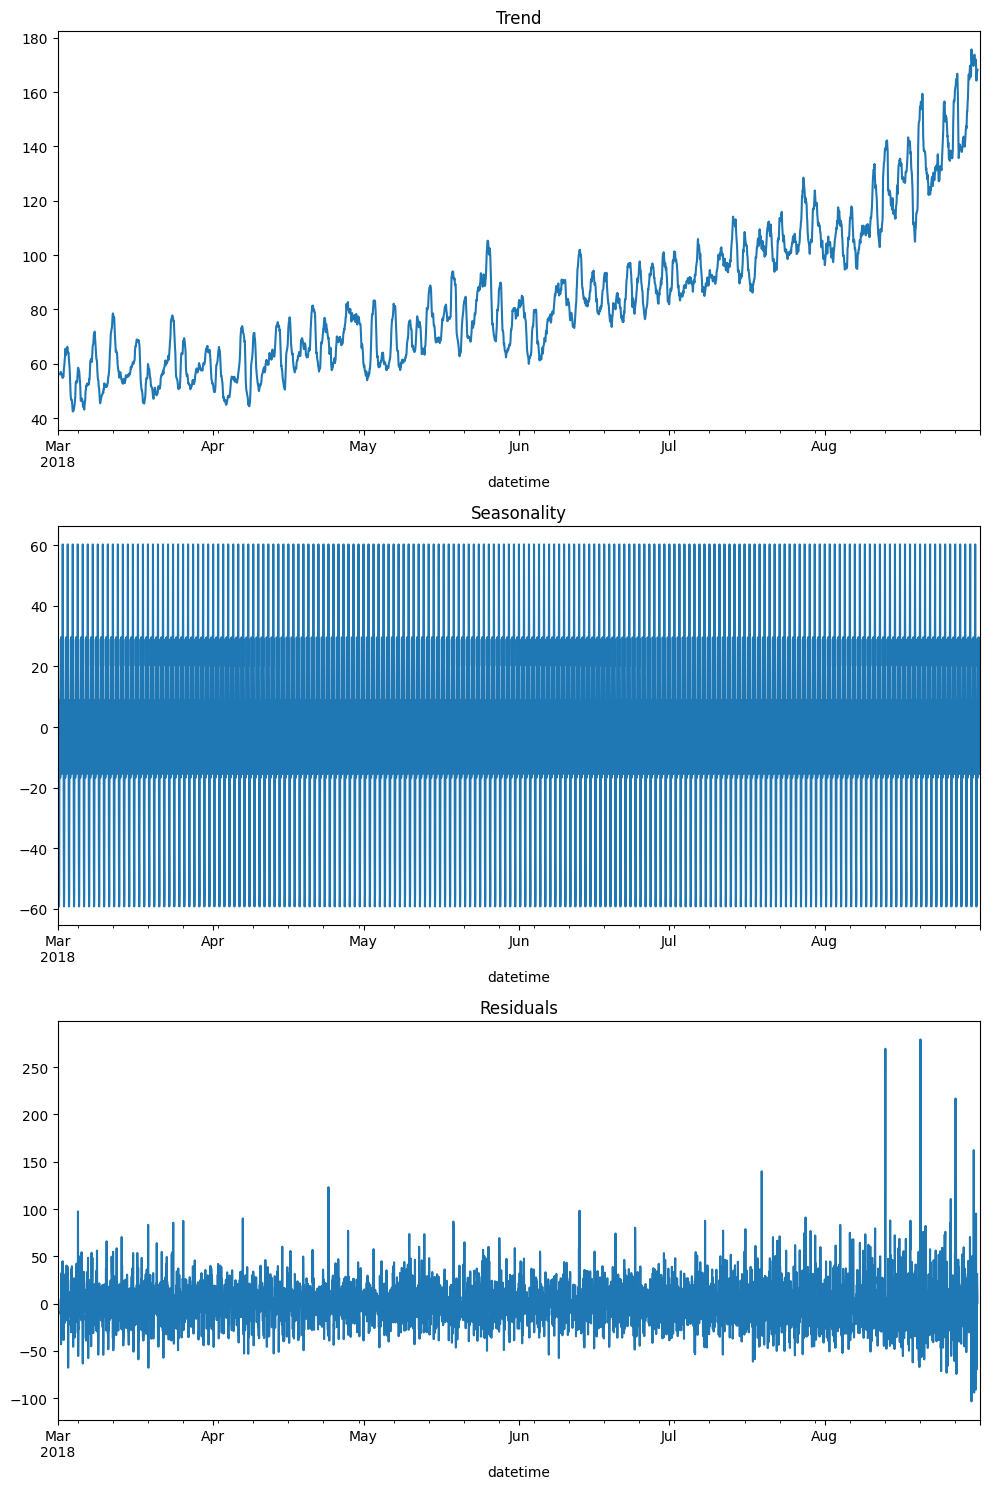

In [27]:
plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

### 2.9. <a id='toc2_9_'></a>Вывод по датасету         [&#8593;](#toc0_)


Перед нами датасет с информацией о заказах такси. Изначально данные даны по каждым 10 минутам. Однако в данном проекте нас интересует более крупный масштаб, поэтому данные были ресемплированы по часу.

Все типы данных корректны, пропусков нет.

Целевой признак (кол-во заказов) без аномалий, все значения вполне реальны.

Согласен тесту Дики-Фулера ряд стационарен при уровне значимости `5%` и НЕ стационарен при `1%`.

Наблюдаются сезонности:
- Дневная: наибольший спрос на такси наблюдается в вечерние часы и особенно ночью (около 12 часов ночи). Это можно объяснить тем, что люди возвращаются из различных мест (рестораны, кино и т.д.), а общественный транспорт уже практически не ходит.
- Недельная: по вторникам и средам количество заказов минимально. А вот в понедельник и четверг их количество куда выше.

Анализ трендов выявил рост кол-ва заказов с каждым месяцем. С марта по июнь рост идет примерно с одной скоростью, а далее ускоряется. Наиболее высокую скорость роста наблюдаем в августе. Но при этом в августе остатков больше, значит в тестовую выборку попадает чуть больше данных, которые модели будет сложнее предсказывать.

## 3. <a id='toc3_'></a>Модели            [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Подготовка         [&#8593;](#toc0_)

In [28]:
def generate_features(df: pd.DataFrame, max_lag: int, rolling_mean_size: int) -> pd.DataFrame:
        df['day'] = df.index.day
        df['dayofweek'] = df.index.dayofweek
        df['hour'] = df.index.hour

        for lag in range(1, max_lag + 1):
            df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

        df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

        return df.dropna()

In [29]:
def get_objective(estimator_class, df: pd.DataFrame, fixed_params: dict):
    def objective(params: dict) -> dict:
        # Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
        for key, value in params.items():
            if isinstance(value, float) and value % 1 == 0:
                params[key] = int(value)

        if 'max_lag' not in params or 'rolling_mean_size' not in params:
            raise ValueError()

        df_with_features = generate_features(df, params['max_lag'], params['rolling_mean_size'])
        X = df_with_features.drop(columns='num_orders')
        y = df_with_features['num_orders']
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TEST_SIZE * 2, shuffle=False)
        # Последние 10% датасета как тестовая выборка отложены
        X_valid, _, y_valid, _ = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

        params_copy = dict(params)
        del params['max_lag']
        del params['rolling_mean_size']
        estimator = estimator_class(**fixed_params, **params)

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_valid)
        rmse = root_mean_squared_error(y_valid, y_pred)

        return {
            'loss': rmse,
            'params': params_copy,
            'status': STATUS_OK
        }

    return objective


In [30]:
def get_model_results(estimator_class,
                      param_space: dict,
                      df: pd.DataFrame,
                      fixed_params: dict,
                      max_evals: int = 100
                      ) -> tuple[dict, float]:
    objective = get_objective(estimator_class, df, fixed_params)
    trials = Trials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f'Finish with best RMSE = {best_score:.2f}')

    return best_params, best_score

### 3.2. <a id='toc3_2_'></a>`LinearRegression`         [&#8593;](#toc0_)

In [31]:
param_space = {
    'max_lag': hp.quniform('max_lag', 1, 15, 1),
    'rolling_mean_size': hp.quniform('rolling_mean_size', 1, 15, 1),
}

fixed_params = {
    'n_jobs': -1
}

In [32]:
best_params_lr, best_score_lr = get_model_results(LinearRegression, param_space, df, fixed_params, max_evals=225)

Finish with best RMSE = 41.47


### 3.3. <a id='toc3_3_'></a>`RandomForestRegressor`         [&#8593;](#toc0_)

In [33]:
param_space = {
    'max_lag': hp.quniform('max_lag', 1, 15, 1),
    'rolling_mean_size': hp.quniform('rolling_mean_size', 1, 15, 1),

    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),         # Количество деревьев в лесу
    'max_depth': hp.quniform('max_depth', 1, 30, 1),                 # Максимальная глубина дерева
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),    # Минимальное количество образцов в листе
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),     # Количество признаков для рассмотрения при поиске лучшего разделения
    'bootstrap': hp.choice('bootstrap', [True, False]),              # Использование bootstrap выборок при построении деревьев
}

fixed_params = {
    'n_jobs': -1,
    'random_state': RANDOM_STATE
}

In [34]:
best_params_rfr, best_score_rfr = get_model_results(RandomForestRegressor, param_space, df, fixed_params, max_evals=1000)

Finish with best RMSE = 46.94


### 3.4. <a id='toc3_4_'></a>`LGBMRegressor`         [&#8593;](#toc0_)

In [35]:
param_space = {
    'max_lag': hp.quniform('max_lag', 1, 15, 1),
    'rolling_mean_size': hp.quniform('rolling_mean_size', 1, 15, 1),

    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 1)
}

fixed_params = {
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

In [36]:
best_params_lgbm, best_score_lgbm = get_model_results(LGBMRegressor, param_space, df, fixed_params, max_evals=200)

Finish with best RMSE = 30.60


### 3.5. <a id='toc3_5_'></a>`CatBoostRegressor`         [&#8593;](#toc0_)

In [37]:
param_space = {
    'max_lag': hp.quniform('max_lag', 1, 15, 1),
    'rolling_mean_size': hp.quniform('rolling_mean_size', 1, 15, 1),

    'iterations': hp.choice('iterations', range(100, 1001)),          # Количество деревьев (итераций)
    'learning_rate': hp.loguniform('learning_rate', -5, 0),           # Скорость обучения (логарифмический масштаб)
    'depth': hp.choice('depth', range(4, 11)),                        # Глубина деревьев
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),                  # Коэффициент L2-регуляризации
    'random_strength': hp.uniform('random_strength', 0, 10),          # Сила случайности при выборе разбиений
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),   # Температура бэггинга
    'border_count': hp.choice('border_count', [32, 64, 128, 254]),    # Количество границ для числовых признаков
    'min_data_in_leaf': hp.choice('min_data_in_leaf', range(1, 21)),  # Минимальное количество данных в листе
    'max_leaves': hp.choice('max_leaves', range(10, 101)),            # Максимальное количество листьев (для 'Lossguide')
}

fixed_params = {
    'thread_count': -1,
    'random_state': RANDOM_STATE,
    'silent': True,
    'grow_policy': 'Lossguide'
}

In [38]:
best_params_cbr, best_score_cbr = get_model_results(CatBoostRegressor, param_space, df, fixed_params, max_evals=200)

Finish with best RMSE = 30.24


## 4. <a id='toc4_'></a>Результаты         [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Сравнение моделей        [&#8593;](#toc0_)

In [39]:
pd.options.display.float_format = '{:.2f}'.format

pd.DataFrame(
    data=[best_score_rfr, best_score_cbr, best_score_lgbm, best_score_lr],
    index=['RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'LinearRegression'],
    columns=['rmse']
).sort_values('rmse', ascending=True)

,rmse
CatBoostClassifier,30.24
LGBMClassifier,30.60
LinearRegression,41.47
RandomForestClassifier,46.94


Все 4 модели показали удовлетворительный результат (метрика меньше максимально допустимой). Однако 2 из них показали куда более высокие результаты, чем 2 другие.

### 4.2. <a id='toc4_2_'></a>Проверка на тесте    [&#8593;](#toc0_)

In [40]:
max_lag = best_params_cbr['max_lag']
rolling_mean_size = best_params_cbr['rolling_mean_size']

del best_params_cbr['max_lag']
del best_params_cbr['rolling_mean_size']

In [41]:
df_for_analysis = generate_features(df, max_lag, rolling_mean_size)
X_for_analysis = df_for_analysis.drop(columns='num_orders')
y_for_analysis = df_for_analysis['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X_for_analysis,
                                                    y_for_analysis,
                                                    test_size=TEST_SIZE,
                                                    shuffle=False)

In [42]:
best_model = CatBoostRegressor(grow_policy='Lossguide',
                               thread_count=-1,
                               random_state=RANDOM_STATE,
                               silent=True,
                               **best_params_cbr)
best_model.fit(X_train, y_train);

In [43]:
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE on test for best model = {rmse:.2f}')

RMSE on test for best model = 41.99


### 4.3. <a id='toc4_3_'></a>Важность признаков       [&#8593;](#toc0_)

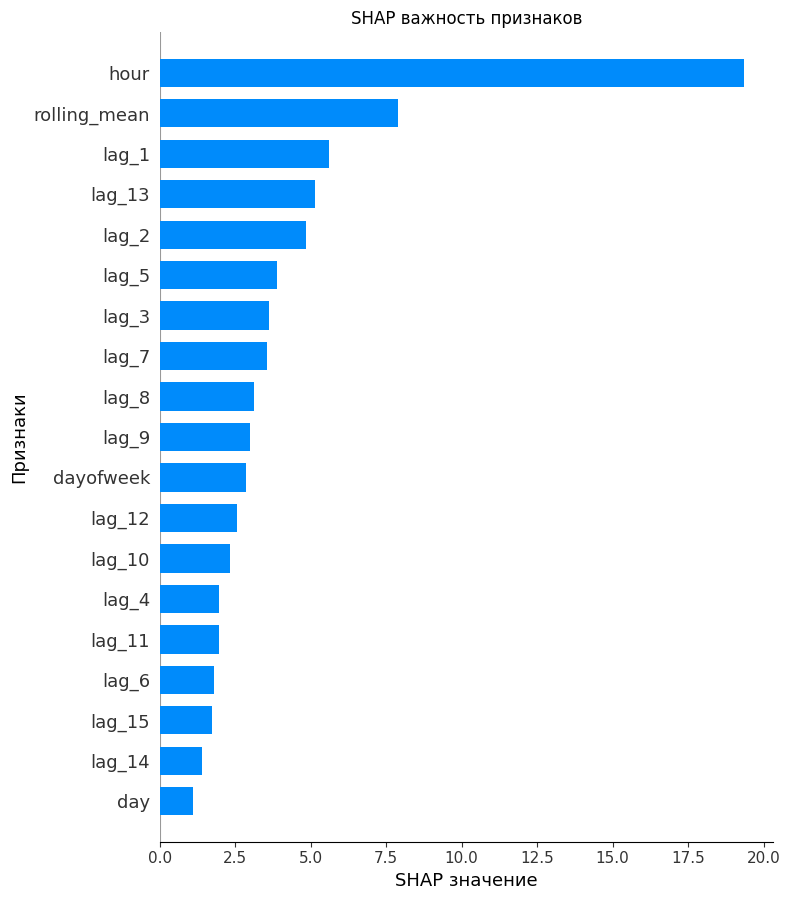

In [44]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_for_analysis)

shap.summary_plot(shap_values,
                  X_for_analysis,
                  color_bar_label='Признаки',
                  show=False,
                  plot_type='bar',
                  show_values_in_legend=True,
                  max_display=100)
plt.title('SHAP важность признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Признаки', fontsize=13)

plt.tight_layout()
plt.show()

### 4.4. <a id='toc4_4_'></a>Анализ предсказаний   [&#8593;](#toc0_)

In [45]:
def plot_result(actual: pd.Series, predicted: pd.Series) -> None:
    if actual.shape != predicted.shape:
        raise ValueError('Длины массивов должны совпадать.')

    if not isinstance(predicted, pd.Series):
        predicted = pd.Series(predicted, actual.index)

    # Ширина столбиков
    width_actual = 0.4     # Ширина для фактических значений
    width_predicted = 0.2  # Ширина для предсказанных значений

    step = len(actual) // 44
    actual = actual.iloc[::step][:44]
    predicted = predicted.iloc[::step][:44]
    indexes = actual.index

    plt.figure(figsize=(20, 8))
    plt.bar(indexes, actual, width=width_actual, label='Фактические значения', alpha=0.7)
    plt.bar(indexes, predicted, width=width_predicted, label='Предсказанные значения', alpha=0.7)

    plt.title('Фактические и предсказанные значения')
    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.xticks(indexes, rotation=90)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

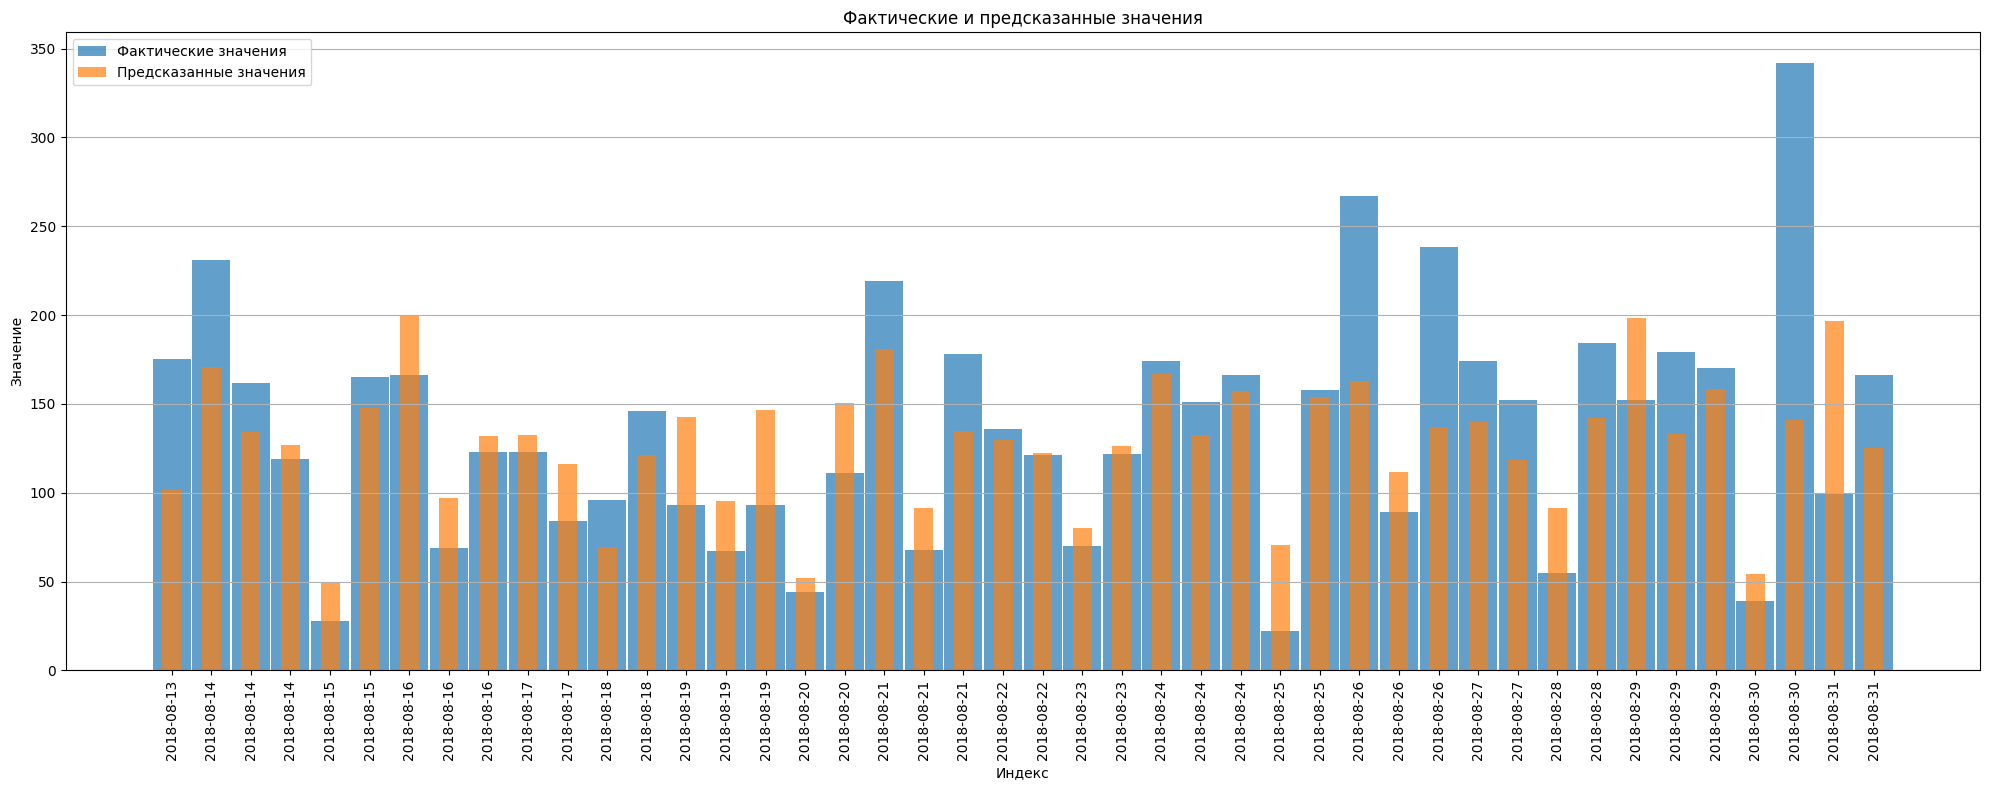

In [46]:
plot_result(y_test, y_pred)

## 5. <a id='toc5_'></a>Общий вывод            [&#8593;](#toc0_)

В рамках данного проекта мы работали с датасетом о заказах такси с шагом 10 минут. Датасет не содержит пропусков. Индекс (дата-время заказа) монотонный. Целевой признак - количество заказов (`num_orders`) содержит адекватную информацию (без аномалий).

Анализ трендов выявил рост с течением времени. Сезонность не показала ничего.

Было протестировано 4 различные модели с перебором гиперпараметров. Помимо гиперпараметров модели перебирались также параметры генерация новых признаков (максимальный лаг и размер окна для расчёта скользящего среднего). В результате 2 модели (*LinearRegression* и *RandomForestRegressor*) показали удовлетворительную метрику (чуть лучше пороговой). А вот 2 другие - *LGBMRegressor* и *CatBoostRegressor* показали неплохие результаты на трейне. С минимальным отрывом победил *CatBoostRegressor*, поэтому именно он рекомендуется для дальнейшей работы. Его результаты на тесте несколько хуже, что частично объясняется тем, что в самом конце датасета наблюдается резкий рост, но эти данные попали в тест и модель их "не видела".

Анализ важности признаков выявил, что 2 ключевыми признаками являются час заказа, скользящее среднее и предыдущее значение (лаг 1) заказа.

Анализ предсказаний не выявил каких-либо закономерностей. Модель ошибается в обе стороны (предсказывает и меньше и больше фактических). Единственное, что можно выделить - это замечание о том, что модель "сильнее" ошибается ближе к концу.